# **Covid**

In [1]:
!pip install kaggle

In [2]:
from google.colab import files

# Upload the kaggle.json file
files.upload()

print("Kaggle.json uploaded successfully.")


Saving kaggle.json to kaggle.json
Kaggle.json uploaded successfully.


In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [4]:
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d sid321axn/covid-cxr-image-dataset-research


Dataset URL: https://www.kaggle.com/datasets/sid321axn/covid-cxr-image-dataset-research
License(s): CC0-1.0
100% 570M/572M [00:22<00:00, 27.1MB/s]
100% 572M/572M [00:22<00:00, 27.1MB/s]


In [6]:
!unzip /content/covid-cxr-image-dataset-research.zip

Archive:  /content/covid-cxr-image-dataset-research.zip
  inflating: COVID_IEEE/covid/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg  
  inflating: COVID_IEEE/covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg  
  inflating: COVID_IEEE/covid/1-s2.0-S0140673620303706-fx1_lrg.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-c.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-001.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-002.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a2.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import random
import matplotlib.pyplot as plt
import shutil
import os
import cv2
import seaborn as sn

In [8]:
file_path = '/content/train'

if not os.path.exists(file_path):
    os.makedirs(file_path)

from distutils.dir_util import copy_tree
fromd = r'/content/COVID_IEEE'
to = r'/content/train'
copy_tree(fromd, to)

# We split data into train, test, and validation
if not os.path.isdir(r'/content/valid'):
    os.makedirs(r'/content/valid')
    os.makedirs(r'/content/test')
    for label in os.listdir(r'/content/train'):
        valid_images = random.sample(os.listdir(r'/content/train/' + label), int(len(os.listdir('/content/train/' + label)) * .20))
        for image in valid_images:
            if not os.path.isdir(f'/content/valid/{label}'):
                os.makedirs(f'/content/valid/{label}')
            shutil.move(f'/content/train/{label}/{image}', f'/content/valid/{label}')
        test_images = random.sample(os.listdir(r'/content/valid/' + label), int(len(os.listdir('/content/valid/' + label)) * .50))

        for image in test_images:
            if not os.path.isdir(f'/content/test/{label}'):
                os.makedirs(f'/content/test/{label}')
            shutil.move(f'/content/valid/{label}/{image}', f'/content/test/{label}')


In [9]:

train_path = r'/content/train'
valid_path = r'/content/valid'
test_path = r'/content/test'

# Preprocess data
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

image_generator = ImageDataGenerator(rescale=1.0/255)

train_data_gen = image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_path,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical'
)

validation_data_gen = image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=valid_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical'
)

test_data_gen = image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical',
    shuffle=False
)


Found 1373 images belonging to 3 classes.
Found 170 images belonging to 3 classes.
Found 165 images belonging to 3 classes.


In [10]:
# Load pretrained MobileNet model and remove the final classification layer
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False


9406464/9406464 [==============================] - 1s 0us/step


In [11]:
# Function to extract features using the pretrained model
def extract_features(data_gen, num_samples):
    features = np.zeros(shape=(num_samples, 7, 7, 1280))
    labels = np.zeros(shape=(num_samples, data_gen.num_classes))

    i = 0
    for inputs_batch, labels_batch in data_gen:
        features_batch = base_model.predict(inputs_batch)
        features[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= num_samples:
            break

    return features, labels


In [12]:

# Extract features for training, validation, and test sets
train_features, train_labels = extract_features(train_data_gen, train_data_gen.samples)
validation_features, validation_labels = extract_features(validation_data_gen, validation_data_gen.samples)
test_features, test_labels = extract_features(test_data_gen, test_data_gen.samples)


1/1 [==============================] - 0s 145ms/step


In [13]:
# Flatten the features
train_features = np.reshape(train_features, (train_data_gen.samples, 7 * 7 * 1280))
validation_features = np.reshape(validation_features, (validation_data_gen.samples, 7 * 7 * 1280))
test_features = np.reshape(test_features, (test_data_gen.samples, 7 * 7 * 1280))



In [14]:

# Train an SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_features, np.argmax(train_labels, axis=1))

SVC(kernel='linear')

In [15]:
# Evaluate the SVM classifier
test_pred = svm_classifier.predict(test_features)
print(classification_report(np.argmax(test_labels, axis=1), test_pred))
conf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), test_pred)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       0.98      0.94      0.96        66
           2       0.94      0.98      0.96        61

    accuracy                           0.97       165
   macro avg       0.97      0.97      0.97       165
weighted avg       0.97      0.97      0.97       165



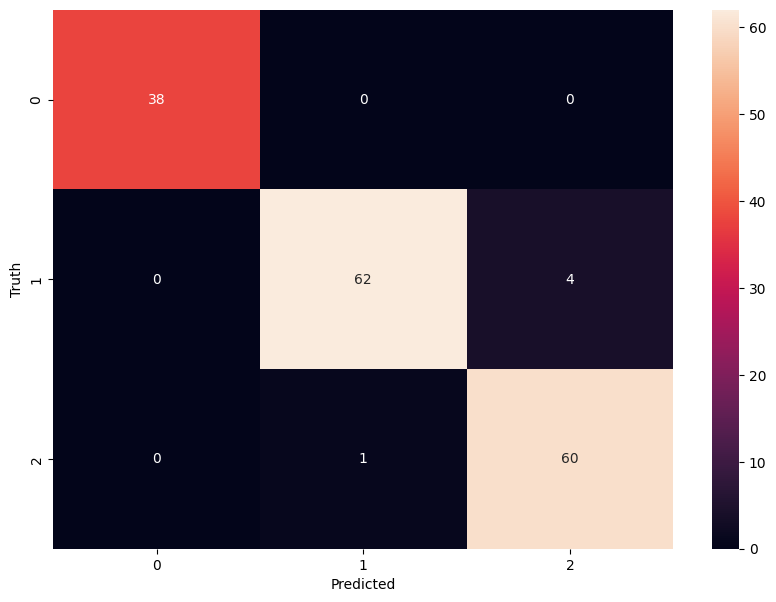

In [16]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sn.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
